# Лабораторная работа 5

Градиентный бустинг с Catboost

Выполнил: 6133, Борисов Дмитрий

Туториал по использованию библиотеки CatBoost: https://github.com/catboost/tutorials/blob/master/ru/ml_session_2018_tutorial_ru.ipynb

Мастер-класс от Яндекса по CatBoost классификации: https://www.youtube.com/watch?v=xl1fwCza9C8

Установка билиотек:

`pip3 install catboost shap ipywidgets
jupyter nbextension enable --py widgetsnbextension`

## 0 Подобрать набор данных для классификации (количество классов не имеет значения) и регрессии. 

Важно наличие числовых и категориальных признаков в данных. Опишите данные, что обозначает каждый столбец, какого типа (категориальный, вещественный, целочисленный, бинарный) данный столбец, при необходимости для категориальных в том числе бинарных признаков привести расшифровку их значений. Можно работать на тех же данных, что и в предыдущей Л.Р.: в этом случае сравнить с результатами лучшего классификатора из предыдущей работы.

### Star dataset to predict star types

A 6 class star dataset for star classification with Deep Learned approaches.

**Dataset Info:**

This is a dataset consisting of several features of stars.

Some of them are:

* __Integer__: Absolute Temperature **(in K)** - This column consists of the Surface temperatures of several stars
* __Real__: Relative Luminosity **(L/Lo)** - This column consists of the Luminosity of several stars calculated with respect to sun(L/Lo)
* __Real__: Relative Radius **(R/Ro)** - This column consists of the Radius of several stars calculated with respect to sun(R/Ro)
* __Real__: Absolute Magnitude **(Mv)** - This column consists of the Absolute Visual magnitude(Mv) of several stars
* __Categorical__: Star Color **(white,Red,Blue,Yellow,yellow-orange etc)** - This column contains the info about the colors of each star after Spectral Analysis
* __Categorical__: Spectral Class **(O,B,A,F,G,K,M)** - This column contains info about the spectral classes of each star(O,B,A,F,G,K,M) 
* __Categorical__: Star Type **(Red Dwarf, Brown Dwarf, White Dwarf, Main Sequence , SuperGiants, HyperGiants)** - This column is the output class (6 classes ranging from 0-5) 0 -> Brown Dwarf 1-> Red Dwarf 2 -> White Dwarf 3-> Main Sequence 4 -> Supergiant 5 -> Hypergiant

Lo = 3.828 x 10^26 Watts (Avg Luminosity of Sun)

Ro = 6.9551 x 10^8 m (Avg Radius of Sun)

In [1]:
from pandas import read_csv

In [2]:
dataset = read_csv('../data/Star_dataset.csv')
dataset

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,red,M
1,3042,0.000500,0.1542,16.60,0,red,M
2,2600,0.000300,0.1020,18.70,0,red,M
3,2800,0.000200,0.1600,16.65,0,red,M
4,1939,0.000138,0.1030,20.06,0,red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,blue,O
236,30839,834042.000000,1194.0000,-10.63,5,blue,O
237,8829,537493.000000,1423.0000,-10.73,5,white,A
238,9235,404940.000000,1112.0000,-11.23,5,white,A


In [3]:
# Задача классификации будет заключаться в определении типа звезды
dataset['Star type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: Star type, dtype: int64

In [4]:
# Краткая информация о типах значений признаков
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


In [5]:
# Краткое описание значений числовых признаков
dataset.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Разбиваем датасет на признаки (data) и классы (labels)

In [6]:
## Для мультиклассовой классификации
# labels = dataset['Star type']
# data = dataset.drop(columns='Star type')

# Для бинарной классификации
data = dataset[dataset['Star type'].isin([0, 1])].reset_index()
labels = data['Star type']
data.drop(columns='Star type', axis=1, inplace=True)
data.shape, labels.shape

((80, 7), (80,))

## 1  Применить классификатор `CatBoostClassifier` к вашему набору данных. 

Обратите внимание, что catboost умеет работать с категориальными признаками (параметр `cat_features` - список индексов категориальных признаков), поэтому использование `pd.factorize / pd.get_dummies` здесь лишнее.    
- Вывести итерацию с наилучшим значением AUC (для бинарной классификации) или наилучшим значением Logloss.
- Вывести значения метрик качества классификации на тестовых данных (accuracy и precision / recall / AUC, если применимо).
- В случае бинарной классификации на основе CatBoostClassifier построить кривые PRC и ROC. Вычислить значения PRC-AUC и ROC-AUC.


Примеры классификатора и построения ROC-кривой: https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
from seaborn import heatmap

In [8]:
# Построение матрицы ошибок и составление отчёта классификации по метрикам
def report_classification(model, Xtest, Ytest, get_info=False):
    pred = model.predict(Xtest)

    print(f'Отчёт по классификации моделью {model}:')
    report = classification_report(Ytest, pred)
    print(report)
    conf_mat = confusion_matrix(Ytest, pred)
    heatmap(conf_mat, annot=True, fmt="d")
    info = {'model':model, 'prediction': pred, 'report':report, "conf_matrix":conf_mat}

    return info if get_info else None

Сохраняем названия категориальных признаков 

In [9]:
cat_features = ['Star color', 'Spectral Class']

In [10]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

Разбиение данных и обучение классификатора

In [11]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data, labels, test_size=0.3, random_state=123)

model = CatBoostClassifier(
    iterations=100,
    loss_function='Logloss'
)
model.fit(
    Xtrain, Ytrain,
    cat_features=cat_features,
    eval_set=(Xtest, Ytest),
    verbose = False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Вывод на экран лучшей итерации классификации c Logloss

In [12]:
print('Лучшая итерация: ', model.get_best_iteration())

Лучшая итерация:  99


Вывод на экран лучших значений Logloss

In [13]:
print('Лучшие значения: ', model.best_score_)

Лучшие значения:  {'learn': {'Logloss': 0.1657763076245884}, 'validation': {'Logloss': 0.18539650955101894}}


Отчёт классификации

Отчёт по классификации моделью <catboost.core.CatBoostClassifier object at 0x00000266768B35B0>:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        10

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



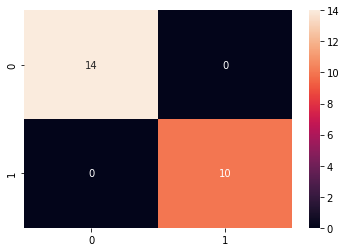

In [14]:
report_classification(model, Xtest, Ytest)

In [15]:
from catboost.utils import get_roc_curve
from catboost import Pool
from sklearn.metrics import auc

### Построение ROC-кривой

In [16]:
eval_pool = Pool(Xtest, Ytest, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = auc(fpr, tpr)

In [17]:
print('ROC-AUC: ', roc_auc)

ROC-AUC:  1.0


In [18]:
import matplotlib.pyplot as plt

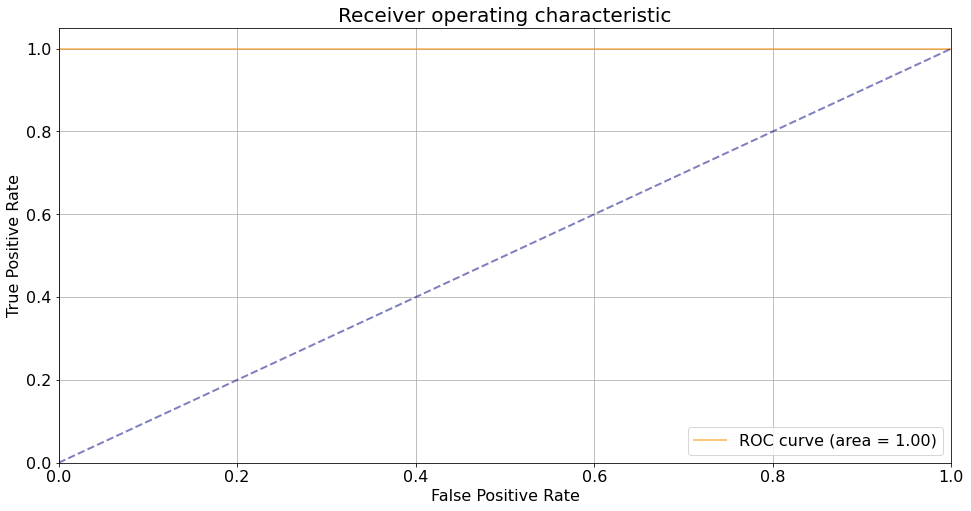

In [19]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

### Построение RPC-кривой

In [20]:
from sklearn.metrics import plot_precision_recall_curve

D:\Programs\Conda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


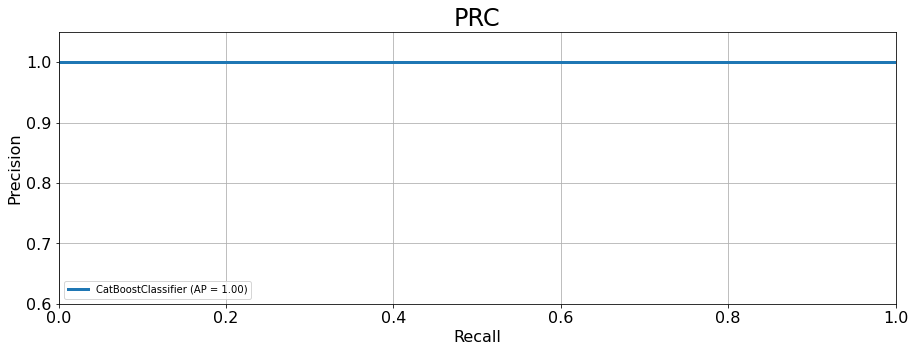

In [21]:
fig, ax = plt.subplots(figsize=(15, 5))

plot_precision_recall_curve(model, Xtest, Ytest, ax=ax, lw = 3)

plt.xlim([0.0, 1.0])
plt.ylim([0.6, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('PRC', fontsize=24)

plt.show()

In [22]:
from pandas import factorize
from sklearn.metrics import average_precision_score 

In [23]:
rpc_auc = average_precision_score(factorize(Ytest)[0], model.predict_proba(Xtest)[:,0]) 
print('RPC-AUC: ', rpc_auc)

RPC-AUC:  0.2658458083323476


## 2 Применить регрессию `CatBoostRegressor` к набору данных для регрессии. 
Вывести номер итерации и значения метрик (MAE и MSE) для наилучшей итерации. Обратите внимание, что в задаче восстановления регрессии целевая переменная имеет непрерывные значения. 

In [24]:
from catboost import CatBoostRegressor

Факторизуем категориальные признаки датасета

In [25]:
reg_data = data.copy()
for col in cat_features:
    reg_data[col] = factorize(reg_data[col])[0]

In [26]:
reg_Xtrain, reg_Xtest, reg_Ytrain, reg_Ytest = train_test_split(reg_data, labels, random_state = 123)

Функция оценки регрессии

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [28]:
def ctRegression(reg_Xtrain, reg_Xtest, reg_Ytrain, reg_Ytest, loss_function='RMSE'):
    reg_model = CatBoostRegressor(use_best_model=True, loss_function=loss_function) 
    reg_model.fit(reg_Xtrain, reg_Ytrain, verbose=False, eval_set=(reg_Xtest, reg_Ytest))

    print('Лучшая итерация', reg_model.get_best_iteration())
    
    pred = reg_model.predict(reg_Xtest)
    print(f'{loss_function}_MAE: {str(mean_absolute_error(reg_Ytest, pred))}')
    print(f'{loss_function}_MSE: {str(mean_squared_error(reg_Ytest, pred))}')

In [29]:
ctRegression(reg_Xtrain, reg_Xtest, reg_Ytrain, reg_Ytest, loss_function='RMSE')

Лучшая итерация 999
RMSE_MAE: 0.057126410917849715
RMSE_MSE: 0.006392285773017388


In [30]:
ctRegression(reg_Xtrain, reg_Xtest, reg_Ytrain, reg_Ytest, loss_function='MAE')

Лучшая итерация 715
MAE_MAE: 0.05664649085888725
MAE_MSE: 0.010338781147761425
